# [ER-190C] Homework 10: Classification Trees
----


### Table of Contents

[Introduction](#intro) <br>
[1. The Data](#data) <br>
[2. Decision Trees From Scratch](#scratch) <br>
[3. Implementing with Scikit-learn](#sk) <br>
[4. Ensemble Methods](#improve) <br>
[5. Comparing Methods](#compare) <br>

**Dependencies:**

In [2]:
import urllib
import os.path
from shutil import copyfile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

In [4]:
!pip install xlrd
!pip install graphviz

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


----

## Introduction <a name = 'intro'> </a>

Decision trees are a powerful prediction method and are easy to interpret. A decision tree can explain exactly why a specific prediction was made. They usually aren't used by themselves, but many trees are used for ensemble methods such as random forests and bagging. Trees are, overall, a relatively more accessible method for predictive modeling since they are used for both regression and classification and can take in both continuous and categorical data.

In this homework, we'll be doing a brief exploration of the CalEnviroScreen dataset, testing out how to make a tree from scratch, as well as implementing various ensemble methods using scikit-learn. It'll be a comprehensive survey of trees and the multitude of algorithms that arise from one tree!


----

## 1. The Data <a name='data'></a>

In this homework, we will be working with the [California Communities Environmental Health Screening Tool (CalEnviroScreen)](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30), which uses demographic and environmental information to identify communities that are susceptible to various types of pollution. The various variables in this dataset contribute to the CES score, which reflects a community's environmental conditions and its vulnerability to environmental pollutants.

We worked with this dataset in lab and this will be one of two homeworks that utilize this dataset.  Although this dataset scores around 8000 of census tracts in California, we'll focus on a subset which makes the decision tree slightly more interpretable. 

In [3]:
def getfile(filename):
    
    if os.path.isfile(filename) == False: # check if you've got the file, if not, download it
        weborlocal = input('File is not in the present working directory.  Get it from the web, or local? ')
        
        if weborlocal == 'web':
            url = input('What is the url? ')
            urllib.request.urlretrieve(url, filename);
        
        elif weborlocal == 'local':
            directory = input('What\'s the file\'s directory? ')
            print(directory+filename)
            
            if os.path.isfile(directory+filename)==True:
                copyfile(directory+filename, filename)
            else:
                print('Can\'t find the file.  Check the directory and make sure the path ends in "/".')
        else:
            print('Please choose "web" or "local".  Try again.')
    
    else:
        print('That file is in the present working directory.')

In [4]:
filename = 'ces3results.xlsx'
getfile(filename)

That file is in the present working directory.


We've just obtained an excel spreadsheet of environmental data from the California EnviroScreen data set. Now, we will format the spreadsheet into a DataFrame object in order to explore its properties. 

Documentation on Pandas' excel methods can be found at [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html#pandas.read_excel).

First we will focus on the first sheet, which contains the data that we'll work with in this homework; run the following cell to look at the four sheets in this excel file.

In [5]:
xl = pd.ExcelFile(filename)
print(xl.sheet_names) # display a list of the sheets in the spreadsheet

['CES3.0FINAL_results', 'Data Dictionary', 'Missing&NAData', 'Demographic profile']


<div class="alert alert-warning">

<b>Question 1.1:</b> Load the first sheet of the Excel file and assign it to the variable `df0`. 

</div>

In [ ]:
...
df0.head()

In [49]:
# SOLUTION
df0 = xl.parse(xl.sheet_names[0]) # display the first sheet as Pandas dataframe
df0.head()

,Census Tract,Total Population,California County,ZIP,City,Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.089387,100.000000,96-100% (highest scores),...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553440,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677825,99.987388,96-100% (highest scores),...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067783,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.968804,99.974776,96-100% (highest scores),...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808662,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.490978,99.962164,96-100% (highest scores),...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991455,97.729852
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030324,99.949552,96-100% (highest scores),...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304296,92.773364


Before we explore this dataset, look at some of the features -- notice that this dataset doesn't include the units of most of it's features. Let's take a look at a different sheet.

Run the following cell to load the data dictionary.

In [50]:
dd = xl.parse('Data Dictionary').rename(columns = {'CalEnviroScreen 3.0: Data Dictionary':'Variable', 
                                                   'Unnamed: 1': 'Description',
                                                   'Unnamed: 2': 'CES Category'})
dd.head(10)

,Variable,Description,CES Category
0,"For more information, see the report and acces...",NaN,NaN
1,CalEnviroScreen 3.0 Webpage,NaN,NaN
2,A web map of the CalEnviroScreen 3.0 results i...,NaN,NaN
3,CalEnviroScreen 3.0 Web Map,NaN,NaN
4,NaN,NaN,NaN
5,Variable Name,Description,CalEnviroScreen Category
6,Census Tract,Census Tract ID from 2010 Census,NaN
7,Total Population,2010 population in census tracts,NaN
8,California County,California county that the census tract falls ...,NaN
9,ZIP,Postal ZIP Code that the census tract falls wi...,NaN


Before we move on, let's check the sheet we just loaded. 

<div class="alert alert-warning">

<b>Question 1.2:</b> Does the number of columns in the first sheet correspond with the number of rows of the variables in the table we just created? Your answer should return a boolean value.

</div>

In [ ]:
...

In [52]:
#SOLUTION
dd.iloc[6:62].shape[0] == df0.shape[1]

True

Now that we've checked if the features and columns correspond, let's move on and take a closer look at the description of these variables.

<div class="alert alert-warning">

<b>Question 1.3:</b> In the `dd` dataframe, drop the rows that contain `Pctl` in the variable name and drop the last column  as well. 

Make sure the shape is correct and that the CES categories match up with the variable names. You can check that on the second page of [this fact sheet](https://oehha.ca.gov/media/downloads/calenviroscreen/fact-sheet/ces30factsheetfinal.pdf).

Note: If you don't pass, rerun the cell that loads this dataframe (two cells before this one)

</div>

In [ ]:
...
...

assert dd.shape == (35, 3)
dd.head(10)

In [53]:
#SOLTUION
dd = dd.iloc[6:62]
dd = dd.drop([i for i in dd.index if 'Pctl' in dd.loc[i][0]]).reset_index(drop=True)

assert dd.shape == (35, 3)
dd

,Variable,Description,CES Category
0,Census Tract,Census Tract ID from 2010 Census,NaN
1,Total Population,2010 population in census tracts,NaN
2,California County,California county that the census tract falls ...,NaN
3,ZIP,Postal ZIP Code that the census tract falls wi...,NaN
4,City,City or nearby city the the census tract falls...,NaN
5,Longitude,Longitude of the centroid of the census tract,NaN
6,Latitude,Latitude of the centroid of the census tract,NaN
7,CES 3.0 Score,"CalEnviroScreen Score, Pollution Score multipl...",NaN
8,CES 3.0 Percentile,Percentile of the CalEnviroScreen score,NaN
9,CES 3.0 Percentile Range,"Percentile of the CalEnviroScreen score, group...",NaN


It seems that not all of the variables have an explicit description of the unit of measurement, or are a scaled or weighted metric. Regardless, we have an idea of the variables we are working with and their units of measurement.

Let's move on and take a look at the data for the city of Berkeley.

<div class="alert alert-warning">

<b>Question 1.4:</b> Find all instances that Berkeley appears in the dataset and assign it to the variable `berkeley`. Then, select the columns `Census Tract`, `ZIP`, `CES 3.0 Score`, `CES 3.0 Percentile Score`, `Housing Burden`, `Poverty`, `Traffic`, `Groundwater Threats`, `Pollution Burden`, and `Drinking Water`.

<br>

Assign this resulting table to `berkeley_ft`.

<br>

Note: For the `CES 3.0 Percentile Score` column, the actual name is 'CES 3.0 \nPercentile Range'
</div>

In [ ]:
berkeley = ...
berkeley_ft = ...
berkeley_ft.head(10)

In [76]:
# SOLUTION
berkeley = df0[df0['City'] == 'Berkeley'].dropna()
berkeley_ft = berkeley[['Census Tract', 'ZIP', 'CES 3.0 Score', 'CES 3.0 \nPercentile Range', 
                        'Housing Burden', 'Poverty','Traffic', 'Groundwater Threats', 'Pollution Burden', 
                        'Drinking Water']]
berkeley_ft.head(10)

,Census Tract,ZIP,CES 3.0 Score,CES 3.0 Percentile Range,Housing Burden,Poverty,Traffic,Groundwater Threats,Pollution Burden,Drinking Water
1905,6001422000,94710,39.951350,76-80%,8.8,41.5,2443.10,236.00,58.519327,70.599583
2361,6001423200,94710,36.091186,71-75%,22.9,42.3,517.07,56.55,44.962177,70.599583
3129,6001424002,94702,30.552611,61-65%,23.7,37.1,551.54,49.30,44.040946,70.599583
3288,6001422100,94710,29.538834,56-60%,24.8,27.5,489.20,70.80,46.131570,70.599583
3536,6001423100,94702,27.744060,56-60%,23.0,30.5,536.16,33.50,42.770954,70.599583
3659,6001422200,94702,26.966131,51-55%,20.6,27.0,506.81,33.80,40.264766,70.599583
4081,6001423300,94702,24.346142,46-50%,19.5,28.6,550.39,55.10,44.664415,70.599583
4127,6001423400,94703,24.135257,46-50%,23.8,30.5,682.35,17.80,37.471131,70.599583
4247,6001420400,94710,23.522346,46-50%,43.7,51.2,2378.83,39.65,50.732530,70.599583
4456,6001422900,94704,22.377374,41-45%,38.1,63.1,730.08,24.75,34.815446,70.599583


Inspect the columns of the resulting table above. Even though these indicators are somewhat self-explanatory, let's take a closer a look at the indicators, how they were measured, and other aspects that aren't necessarily very clear upon first glance. Take a look at the [CES documentation](https://oehha.ca.gov/media/downloads/calenviroscreen/report/ces3report.pdf) and answer the following question.

<div class="alert alert-warning">

<b>Question 1.5:</b> Look through the section on indicator description and analysis. For each of the indicators (or variables) for the columns left of `CES 3.0 Score`, find the following information:

- How is the indicator measured? <br>
- What is the data source? <br>
- Why is this indicator used for the CES score (why is is relevant)? <br>

</div>

**Housing Burden**  <br>
Measurement:        <br>
Data source:        <br>
Relevance:

**Poverty**         <br>
Measurement:        <br>
Data source:        <br>
Relevance:

**Traffic**        <br>
Measurement:       <br>
Data source:       <br>
Relevance:

**Groundwater Threats** <br>
Measurement:            <br>
Data source:            <br>
Relevance:

**Pollution Burden** <br>
Measurement:         <br>
Data source:         <br>
Relevance:

**Drinking Water** <br>
Measurement:         <br>
Data source:         <br>
Relevance:

-----

We also dropped the percentiles of all of the indicators in our data dictionary. Even though the percentiles show relative scores of the indicators, but we lose the original measurements. The percentiles are used in the final calculation of the CES score, in which the percentiles of the indicators in the four groups are averaged. The formula for the CES score is the shown below.

<img src="ces_calc.png" height=25 width=400>

Let's compare the two rows in our table, specifically the rows with Census Tract `6001421100` and `06001422000`. Run the following cell to load the two rows.

<a name='berkeleytable'></a>

In [80]:
ind1 = berkeley_ft[berkeley_ft['Census Tract'] == 6001421100.0]
ind2 = berkeley_ft[berkeley_ft['Census Tract'] == 6001422000.0]
ind1.append(ind2)

,Census Tract,ZIP,CES 3.0 Score,CES 3.0 Percentile Range,Housing Burden,Poverty,Traffic,Groundwater Threats,Pollution Burden,Drinking Water
7920,6001421100,94708,1.473015,1-5% (lowest scores),11.7,7.9,264.93,0.0,15.788499,70.599583
1905,6001422000,94710,39.951350,76-80%,8.8,41.5,2443.10,236.0,58.519327,70.599583


These two communities are extremely different -- one has an extremely low score and one has a high score, and the values in the features are also pretty varied. Let's take a look at where their scores lie in various histograms of the features.

<div class="alert alert-warning">

<b>Question 1.6:</b> Plot a distribution for the `Poverty` variable of all Berkeley tracts as well as for `Pollution Burden`. Along with these histograms, plot the points in which these two tracts lie within the distribution.

Hint: Use `plt.scatter` for the individual points.

</div>

In [ ]:
...
...
...

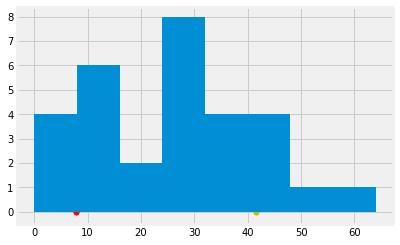

In [81]:
# SOLUTION (poverty hist)
plt.hist(berkeley_ft['Poverty'], bins=np.arange(0, 71, 8))
plt.scatter(ind1['Poverty'].values, y=0, c='r', s=30)
plt.scatter(ind2['Poverty'].values, y=0, c='y', s=30);

In [ ]:
...
...
...

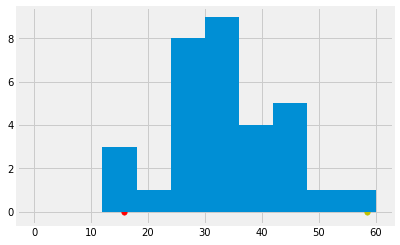

In [82]:
# SOLUTION (pollution burden hist)
plt.hist(berkeley_ft['Pollution Burden'], bins=np.arange(0, 61, 6))
plt.scatter(ind1['Pollution Burden'].values, y=0, c='r', s=30)
plt.scatter(ind2['Pollution Burden'].values, y=0, c='y', s=30);

Lastly, let's take a look at the demographic profiles of these two communities. This data is stored in the `Demographic profile` sheet.

<div class = "alert alert-warning">

<b>Question 1.7:</b> Similar to what we did earlier by comparing the two rows, compare the two tracts' demographic information (i.e. display the two rows together). We've loaded the sheet into a dataframe `dp` and have renamed the columns for you.

</div>

In [ ]:
dp = xl.parse('Demographic profile')
dp = dp.rename(columns = {'Census Tract ': 'Census Tract',
                          'Age group from 2010 Census (%)':'Children < 10 (%)', 
                          'Unnamed: 7':'Pop 11-64 years (%)',
                          'Unnamed: 8':'Elderly > 65 (%)', 
                          'Race or ethnicity from 2010 Census (%)':'Hispanic (%)',
                          'Unnamed: 10':'White (%)',
                          'Unnamed: 11':'African American (%)', 
                          'Unnamed: 12': 'Native American (%)', 
                          'Unnamed: 13':'Asian American (%)', 
                          'Unnamed: 14': 'Other (%)'})

# YOUR CODE HERE
demo1 = ...
demo2 = ...
demo1.append(demo2)

In [83]:
# SOLUTION
dp = xl.parse('Demographic profile')
dp = dp.rename(columns = {'Census Tract ': 'Census Tract',
                          'Age group from 2010 Census (%)':'Children < 10 (%)', 
                          'Unnamed: 7':'Pop 11-64 years (%)',
                          'Unnamed: 8':'Elderly > 65 (%)', 
                          'Race or ethnicity from 2010 Census (%)':'Hispanic (%)',
                          'Unnamed: 10':'White (%)',
                          'Unnamed: 11':'African American (%)', 
                          'Unnamed: 12': 'Native American (%)', 
                          'Unnamed: 13':'Asian American (%)', 
                          'Unnamed: 14': 'Other (%)'})

demo1 = dp[dp['Census Tract'] == 6001421100.0]
demo2 = dp[dp['Census Tract'] == 6001422000.0]
demo1.append(demo2)

,Census Tract,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,Total Population,California County,Children < 10 (%),Pop 11-64 years (%),Elderly > 65 (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other (%)
7921,6.001421e+09,1.473015,0.113507,1-5% (lowest scores),1992.0,Alameda,9.5,63.3,27.2,5,76.5,1.8,0,12,4.6
1906,6.001422e+09,39.951350,75.974272,76-80%,1756.0,Alameda,9.1,82.5,8.4,12.6,43.3,28,0.2,10,5.9


If you're curious, you can take a look at where these census tracts are located by inputting the coordinates in [maps](https://www.google.com/maps).
- Coordinates for the first row: (+37.8994340, -122.2661928)
- Coordinates for second row: (+37.8590327, -122.3013426)

You can then find the tract areas by using this [web tool](https://data.cityofberkeley.info/Demographics/Census-Tract-Polygons-2010/peq3-2arw) provided by the city of Berkeley!

----

## 2. A Decision Tree From Scratch <a name = 'scratch'></a>




Let's start by creating a decision tree from scratch! Even though trees are pretty easy to interpret, there's a lot that runs to create the final tree. We'll walk through creating a tree which will hopefully help our intuition when we use scikit-learn later in this homework.

First, let's take a very small subset of our data so that our tree will be easy to work with. There are a few things we're doing here to make this process more digestible -- we're taking a sample of 10 from the table and we are classifying the top and bottom groups of the CES dataset.

<div class="alert alert-warning">

<b>Question 2.1:</b> In the following cell, we've loaded the first sheet of the excel file into a dataframe called `data`. 

<br>

First, find the indices of the groups with the highest (96-100th percentiles) and lowest (1-5th percentiles) scores. You should have two arrays, and assign them to the variables `top` and `bottom` respectively. 

<br>

Then, fill out the ellipses in the `sample` dataframe method -- take a sample of 10, and set the random_state to 1.

</div>

In [ ]:
data = data = df0.rename(columns={'CES 3.0 \nPercentile Range':'CES 3.0 Percentile Range'})

...
...

scratch = data.iloc[top.append(bottom)].dropna()
scratch = scratch[["Groundwater Threats", 
                   "Drinking Water",           # YOUR CODE HERE
                   "CES 3.0 Percentile Range"]].sample(...)
scratch

In [31]:
# SOLUTION
data = df0.rename(columns={'CES 3.0 \nPercentile Range':'CES 3.0 Percentile Range'})

top = data[data['CES 3.0 Percentile Range'] == '96-100% (highest scores)'].index
bottom = data[data['CES 3.0 Percentile Range'] == '1-5% (lowest scores)'].index

scratch = data.iloc[top.append(bottom)]
scratch = scratch.dropna().loc[:,["Groundwater Threats", "Drinking Water", 
                                "CES 3.0 Percentile Range"]].sample(10, random_state=1)
scratch

,Groundwater Threats,Drinking Water,CES 3.0 Percentile Range
7672,0.00,204.133310,1-5% (lowest scores)
7541,1.50,70.599583,1-5% (lowest scores)
19,24.00,681.195604,96-100% (highest scores)
223,4.00,664.069078,96-100% (highest scores)
7535,5.00,67.043782,1-5% (lowest scores)
279,4.25,644.868868,96-100% (highest scores)
203,15.00,495.257331,96-100% (highest scores)
7586,0.00,437.425659,1-5% (lowest scores)
285,6.00,835.976652,96-100% (highest scores)
383,0.75,557.338833,96-100% (highest scores)


The first the we want to do when we building a tree is how can we create each split in the tree. To do so, we'll start with calculating the gini index. 

The gini index (also called gini coefficient) is the cost function that we use to evaluate splits in our dataset. It gives us an idea of the quality of a split by how "pure" it is, or how mixed the two classes are after the split. The value ranges from 0 to .5. For a two class problem, 0 denotes a perfect separation while 0.5 is the worst split, (a split that results in 50/50 classes in each group result).

The index is calculated as follows:

$$ G = \sum_{k = 1}^{K}{\hat{p}_{mk}(1 - \hat{p}_{mk})} = 1 - \sum_{k = 1}^{K} \hat{p}^2_{mk}$$

where $G$ is the Gini index, and $\hat{p}_{mk}$ is the proportion of count in each variable.

<div class="alert alert-warning">

<b>Question 2.2:</b> Take a look at the following cell, which contains the code in order to calculate the gini index. There are letters following three pound symbols. Write down what the line below is doing for each letter.

</div>

In [32]:
def gini_index(groups, classes):
    ### A ###
    n_instances = float(sum([len(group) for group in groups]))
    ### B ###
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        ### C ###
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        ### D ###
        gini += (1.0 - score)
    return gini

***YOUR ANSWERS HERE***

**A)**

**B)**

**C)**

**D)**

***SOLUTION:***
- a) count samples at split point
- b) sum weighted Gini index for each group
- c) score the group based on the score for each class
- d) weight the group score by its relative size

------

Now, we can look at creating a split. A split is comprised of an attribute in the dataset and a value and creating one involves three parts.

1. Calculating the gini index
2. Splitting a dataset
3. Evaluating all splits

We'll look at the second step now!

Splitting a dataset means separating a dataset into two lists of rows given the index of an attribute and a split value for that attribute. Once we have the two groups, we can use the gini index above to evaluate the cost of the split. In this procedure, we iterate over each row to check if the attribute value is below or above the split value and then we'll assign it to the left or right group respectively.

Run the following cell to load the function.

In [33]:
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

<div class="alert alert-warning">

<b>Question 2.3:</b> What does the group `right` in this function represent?

</div>

***YOUR ANSWER HERE***

**Solution:**  the right group contains all rows with a value at the index above or equal to the split value.

----
We can create our splits now. Given a dataset, we must check every value on each attribute as a candidate split, evaluate the cost of the split and find the best possible split we could make. The lowest gini score across all the features would then be chosen as the best split and a node would be created.

We will use a dictionary to represent a node in the decision tree as we can store data by name. When selecting the best split and using it as a new node for the tree we will store the index of the chosen attribute, the value of that attribute by which to split and the two groups of data split by the chosen split point.

The function below runs this procedure. Run the cell to load function.

In [34]:
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index = index
                b_value = row[index]
                b_score = gini
                b_groups = groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

We have all of the tools to find the best splits of the tree -- let's see how we can use them to *build* one from the ground up (or from the top since trees are inverted...). 

Building a tree takes two main steps: finding leaves (e.g. when to stop the tree) and recursively splitting the tree.

The following cell contains the function that returns the most common output in a list of rows.

In [35]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

<div class="alert alert-warning">

<b>Question 2.4:</b> What is a problem when fitting a tree too deeply? What about having too many nodes?

</div>

***YOUR ANSWER HERE***

----

We're almost there! The following cell contains the function that performs the recursive splitting. 

Here are the steps of this procedure:

1. Two groups of data split by the node are extracted and deleted from the node. The node no longer requires access to these data when we work on the node.
2. We check if either left or right group of rows is empty and if so we create a terminal node using the data and computed scores we have.
3. Check if we have reached our maximum depth. If we have, create a terminal node.
4. If the group of rows is too small, we process the left child and create a terminal node. Otherwise, we create and add the left node in a depth-first fashion until the bottom of the tree is reached on this branch.
5. Right side is then processed in the same manner, as we rise back up the constructed tree to the root.

<div class="alert alert-warning">

<b>Question 2.5:</b> Similar to question 2.2, look at the following cell and note what each control case is doing in the `split` function.

</div>

In [36]:
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    ### A ###
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    ### B ###
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    ### C ###
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    ### D ###
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

***YOUR ANSWER HERE***

**A)**

**B)**

**C)**

**D)**

**Solution**
- a. check for an empty split
- b. check for max depth
- c. process left child
- d. process right child

----

Awesome! We're ready to build our tree. In the following cell, we have our `build_tree` and `print_tree` function. Most of the steps were abstracted away in `get_split` and `split` functions. Before we use the function, we can't directly use a pandas dataframe or series as input to this function.

<div class="alert alert-warning">

<b>Question 2.6:</b> In the same cell, assign a list of the rows of the dataframe to the variable `rows`. Run the cell and see the resulting tree. What do the inqualities represent? How does it relate to the data we inputted into the tree?

</div>

In [ ]:
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

# YOUR CODE HERE       
rows = ...
scratch_tree = build_tree(rows, 1, 1)
print_tree(scratch_tree)

In [113]:
# SOLUTION
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

# YOUR CODE HERE       
rows = [scratch.iloc[i].values[:] for i in range(scratch.shape[0])]
scratch_tree = build_tree(rows, 1, 1)
print_tree(scratch_tree)

[X2 < 495.257]
 [1-5% (lowest scores)]
 [96-100% (highest scores)]


***YOUR ANSWER HERE***

----

Just for fun, we can also use this tree for prediction! Let's use the observation that had the lower score from [earlier](#berkeleytable) in the table of the two Berkeley census tracts we chose. Run the following cell to see the expected and a predicted value from the observation!

In [114]:
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

row = ind1[['Groundwater Threats', 'Drinking Water', 'CES 3.0 \nPercentile Range']].values.tolist()[0]
prediction = predict(scratch_tree, row)
print('Expected: ', ind1['CES 3.0 \nPercentile Range'].values[0])
print('Got: ', prediction, '\n')

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 



We got the expected percentile range! Now that we have a better idea of how a tree works under the hood, let's move on to scikit-learn and create a more complex tree.

---

## 3. Implementing with Scikit-Learn <a name = 'sk'></a>

Since our data has quite the amount of features, creating and tuning a tree from scratch would be a hassle and would not necessarily lead to optimal results. Here's where scikit-learn comes in and streamlines the process for us.

We'll be using scikit-learn's `DecisionTreeClassifier` ([documenation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) in this section and use a larger subset of the data to create a more complex model.

In [113]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree

data.head()

,Census Tract,Total Population,California County,ZIP,City,Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.089387,100.000000,96-100% (highest scores),...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553440,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677825,99.987388,96-100% (highest scores),...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067783,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.968804,99.974776,96-100% (highest scores),...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808662,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.490978,99.962164,96-100% (highest scores),...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991455,97.729852
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030324,99.949552,96-100% (highest scores),...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304296,92.773364


----

### 3.1. The First Tree

For our first model, we'll use the features to predict which score bracket a certain tract lies in, namely we want to use these features to predict the `CES 3.0 Percentile Range`. For the sake of interpretability, we'll focus on the 91th percentile and above, and up to the 10th percentile of scores.

<div class="alert alert-warning">

<b>Question 3.1.1:</b> Before we move on, what is a problem that can stem from using such a specific subset of our data to build a classifier?

</div>

***Your Answer Here***

Let's take a look at the scores that have been binned already in the dataset so we know how to set up our model. Run the following cell to see them!

In [77]:
data['CES 3.0 Percentile Range'].unique()

array(['96-100% (highest scores)', '91-95%', '86-90%', '81-85%', '76-80%',
       '71-75%', '66-70%', '61-65%', '56-60%', '51-55%', '46-50%',
       '41-45%', '36-40%', '31-35%', '26-30%', '21-25%', '16-20%',
       '11-15%', '6-10%', '1-5% (lowest scores)'], dtype=object)

It looks like we have a total of four values that our tree can potentially classify if we want to take the top and bottom 10% of scores.

<div class="alert alert-warning">

<b>Question 3.1.2:</b> Get the index values for the data in the `96-100% (highest scores)` and `91-95%` range, and assign the values to the variable `pct90`. Do the same for `6-10%` and `1-5% (lowest scores)`, assigning the resulting values to the variable `pct10`.

<br>

Then, use `pct90` and `pct10` to get the resulting table and reassign it to `data`. This table should only contain the four ranges in the column `CES 3.0 Percentile Range`

</div>

In [ ]:
...
print(pct90)

...
...
...
print(pct10)

data = ...

assert len(data['CES 3.0 Percentile Range'].unique()) == 4

data.head()

In [78]:
# SOLUTION
pct90 = data[data['CES 3.0 Percentile Range'] > '9'].index
print(pct90)

bottom = data[data['CES 3.0 Percentile Range'] == '1-5% (lowest scores)'].index
bottom2 = data[data['CES 3.0 Percentile Range'] == '6-10%'].index
pct10 = bottom.append(bottom2)
print(pct10)

data = data.loc[pct90.append(pct10)]

assert len(data['CES 3.0 Percentile Range'].unique()) == 4

data.head()

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            783, 784, 785, 786, 787, 788, 789, 790, 791, 792],
           dtype='int64', length=777)
Int64Index([7532, 7533, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542,
            ...
            7520, 7521, 7522, 7523, 7524, 7527, 7528, 7529, 7530, 7531],
           dtype='int64', length=716)


,Census Tract,Total Population,California County,ZIP,City,Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.089387,100.000000,96-100% (highest scores),...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553440,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677825,99.987388,96-100% (highest scores),...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067783,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.968804,99.974776,96-100% (highest scores),...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808662,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.490978,99.962164,96-100% (highest scores),...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991455,97.729852
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030324,99.949552,96-100% (highest scores),...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304296,92.773364


Now that we have our desired observations, let's filter through the certain features we want to use in our classification tree. Remember that a tree can use both continuous and categorical data, but we probably don't want to work with features like the county or zip code since it would clutter our data if we wanted to encode them. Run the following cell to drop the columns as well as the NaN values.

In [79]:
data = data.drop(columns = ['Census Tract', 'CES 3.0 Score', ' CES 3.0 Percentile', 
                            'California County', 'ZIP', 'City', 'Longitude', 'Latitude'])
data = data.dropna()
data.head()

,Total Population,CES 3.0 Percentile Range,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,3174,96-100% (highest scores),0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553440,99.697314
1,6133,96-100% (highest scores),0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067783,98.108210
2,3167,96-100% (highest scores),0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808662,99.987388
3,6692,96-100% (highest scores),0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991455,97.729852
4,2206,96-100% (highest scores),0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304296,92.773364


The last thing we need to do before we create our decision tree is to drop the `Pctl` columns, as well as create the testing, training, and validation sets.

<div class="alert alert-warning">

<b>Question 3.1.3:</b> Drop all columns that contain the string `Pctl` for our set of features. Don't forget to drop the percentile range column. We don't want that in our features! 

Assign the resulting table the variable `features` and assign the percentile ranges to the variable `target`.

Lastly, create the training, testing, and validation sets by splitting the set into training and testing first, then split the training test. Use `random_state = 1` both times, and create an 80/20 train/test split, and a 75/25 train/validation split.

</div>

In [ ]:
drop_columns = ...
...

features = ...
target = ...

# split test set
X, X_test, y, y_test = train_test_split(...)

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(...)

In [80]:
#SOLUTION 
drop_columns = [i for i in data.columns if 'Pctl' in i]
drop_columns.append('CES 3.0 Percentile Range')

features = data.drop(columns=drop_columns)
target = data['CES 3.0 Percentile Range']

# split test set
X, X_test, y, y_test = train_test_split(features, target, random_state = 1, test_size = .2)

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1, test_size = 0.25)

Awesome! We can finally create a tree! 

<div class="alert alert-warning">

<b>Question 3.1.3:</b> Instantiate a `DecisionTreeClassifer` model and call it `first_tree`. Fit the model using the training data, and score it using both the training and validation set. Assign the scores to the variables `train_score` and `val_score` respectively.

</div>

In [ ]:
...
...

print("Number of features: {}".format(first_tree.tree_.n_features))
print("Number of nodes (leaves): {}".format(first_tree.tree_.node_count), "\n")

...
...

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

In [82]:
#SOLUTION
first_tree = DecisionTreeClassifier()
first_tree.fit(X_train, y_train)

print("Number of features: {}".format(first_tree.tree_.n_features))
print("Number of nodes (leaves): {}".format(first_tree.tree_.node_count), "\n")

train_score = first_tree.score(X_train, y_train)
val_score = first_tree.score(X_val, y_val)

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

Number of features: 25
Number of nodes (leaves): 117 

Train Score:  1.0
Validation Score:  0.8963210702341137


The score isn't too shabby for a tree that was put together pretty quickly. The nice part about decision trees is that they're easy to visualize and interpret and with scikit-learn, we can export the an image of the tree. Unfortunately, due limitations on DataHub, we can't output an image directly in a notebook. 

Luckily, we can copy the code and visualize the tree on [Webgraphviz](http://webgraphviz.com). By running the following cell, you'll see a pretty long output -- follow the link and copy and paste the output to get a visualization of the decision tree we fit!

In [ ]:
import graphviz
print(tree.export_graphviz(first_tree, feature_names=X.columns))

<div class="alert alert-warning">

<b>Question 3.1.4:</b> What does each line in the box mean?

</div>

***YOUR ANSWER HERE*** <br>
First line:

Second line:

Third line:

Fourth Line:

<div class="alert alert-warning">

<b>Question 3.1.4:</b>   Based on the visualization, can you see any problems or pitfalls with the model we just created? Can you infer the "most and least important" features?

</div>

***YOUR ANSWER HERE***

----
<a name='first'></a>
With scikit-learn, we're also able to check the feature importances. Running the following cell, we can see the features and the their importance based on the data we used to fit the tree -- this can be helpful when tuning or pruning the tree!

In [ ]:
pd.DataFrame({'Feature': X.columns, 'Importance': first_tree.feature_importances_})

-----

### 3.2. Tuning hyper parameters and Pruning

We've had a good look at what we can do with a decision tree in using scikit-learn. Let's dive into learning about the hyperparameters, which can help improve our classification model. Again, the documentation for `DecisionTreeClassifier` is linked [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

If you noticed in the tree earlier, there were a *lot* of nodes. Some of these nodes have a gini score of 0 or have small sample numbers. We can overcome these problems by tweaking the hyperparameters of the tree. 

In the following cell, we have almost the exact same code from earlier, but we've added two parameters: `max_leaf_nodes` and `max_features`. Let's try two or three sets of different values for these two parameters and see how much we can improve our original model.

In [669]:
tuned_tree = DecisionTreeClassifier(max_leaf_nodes=..., max_features=...)
tuned_tree.fit(X_train, y_train)

print("Number of features: {}".format(tuned_tree.tree_.n_features))
print("Number of nodes (leaves): {}".format(tuned_tree.tree_.node_count),"\n")

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

Number of features: 25
Number of nodes (leaves): 69 

Train Score:  0.9787709497206704
Validation Score:  0.9130434782608695


Were you able to obtain validation score higher than what we had originally? It probably took some time to figure out which values were better than others.

Fortunately, we don't have to test various parameters by manually inputting them and running the cell, which would be exhausting! Instead, we can use [`RandomizedSearchCV` from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to help us find optimal parameters. 

It takes in a model, a distribution of parameters we want to test in the model, and other parameters that we can tweak. We'll only use `cv` and `n_iter` along with the two required arguments. 

The parameter distribution is a dictionary that takes in the parameter name as a key and a range of random values that we want to test. We'll be using `randint` from scipy.stats. Run the following cell -- we will also fit the CV search which will take some time.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 25),
              'max_depth': randint(1, 10)}

rnd_search = RandomizedSearchCV(tuned_tree, param_distributions=param_dist, 
                                cv=10, n_iter=200)
rnd_search.fit(X_train, y_train)

After fitting our data, we can check the score and the values for the parameters that return the "best" score. Run the following cell to get these values!

In [ ]:
print(rnd_search.best_score_)
print(rnd_search.best_params_)

<div class="alert alert-warning">

<b>Question 3.2.1:</b> With our new parameters, set the parameters of `tuned_tree` to the ones that we found using the randomized search. Then, score the model using the training and validation sets.

</div>

In [ ]:
...
...

tuned_train_score = ...
tuned_val_score = ...

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

In [674]:
#SOLUTION (NOTE: parameters might be different for students)
tuned_tree.set_params(max_features=18, max_leaf_nodes=40)
tuned_tree.fit(X_train, y_train)

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

Train Score:  0.9832402234636871
Validation Score:  0.8929765886287625


Awesome! Hopefully this tuned tree performed better than our original one (due to the random samples, it's hard to say). Let's also print out the feature scores like we did initially. Do you see a difference between the feature importances of the tuned tree compared to those of the first tree?

In [ ]:
pd.DataFrame({'Feature':X_train.columns, 'Importance': tuned_tree.feature_importances_})

Lastly, for this tuned tree, let's take a look at how adjusting the hyperparameters altered the decision tree. Like last time, copy and paste the code into [Webgraphviz](http://webgraphviz.com) to visualize the tree.

In [ ]:
print(tree.export_graphviz(tuned_tree, feature_names=X.columns))

----

We briefly covered hyperparameter tuning -- let's move on to pruning our tree. Unfortunately, pruning is not a feature built into scikit-learn yet, but we can use the structure of the tree (which is readily available by calling `first_tree.tree_`) to traverse its nodes.

The following is a function that prunes leaves and nodes based on how many samples we want a node to have.

In [26]:
def prune(decision_tree, min_samples_leaf = 1):
    decision_tree.min_samples_leaf = min_samples_leaf
    tree = decision_tree.tree_
    
    for i in range(tree.node_count):
        n_samples = tree.n_node_samples[i]
        if n_samples <= min_samples_leaf:
            #sklearn.tree structure: -1 denotes a leaf
            tree.children_left[i] = -1
            tree.children_right[i] = -1

For this pruned tree, let's compare it to the `first_tree` model -- so we won't set any specific hyperparameters.

<div class="alert alert-warning">

<b>Question 3.2.2:</b> Instantiate another model and assign it to `pruned_tree`. Fit it with the training data and then prune the tree -- try your best to find an optimal value. It doesn't necessarily have to be high, but try to find a better score than our initial model.

</div>

In [ ]:
...
...

print(sum(pruned_tree.tree_.children_left < 0))

...

print(sum(pruned_tree.tree_.children_left < 0), '\n')

print('Train Score: ', pruned_tree.score(X_train, y_train))
print('Validation Score: ', pruned_tree.score(X_val, y_val))

In [676]:
# SOLUTION
pruned_tree = DecisionTreeClassifier()
pruned_tree.fit(X_train, y_train)

print("Nodes before pruning: ", sum(pruned_tree.tree_.children_left < 0))

prune(pruned_tree, min_samples_leaf = 8)

print('Nodes after pruning:', sum(pruned_tree.tree_.children_left < 0), '\n')

print('Train Score: ', pruned_tree.score(X_train, y_train))
print('Validation Score: ', pruned_tree.score(X_val, y_val))

Nodes before pruning:  59
Nodes after pruning: 71 

Train Score:  0.9832402234636871
Validation Score:  0.903010033444816


Let's also take a look at the feature importances. Do they look any different from the previous two models?

In [ ]:
pd.DataFrame({'Feature':X.columns, 'Importance': pruned_tree.feature_importances_})

Run the following cell and copy and paste the output on [webgraphviz](http://webgraphviz.com).

In [ ]:
print(tree.export_graphviz(pruned_tree, feature_names = X.columns))

<div class="alert alert-warning">

<b>Question 3.2.3:</b> Take a look at each of the three trees. What did adjusting the hyperparameters do to the tree? What about the pruning? Does it make your model easier to understand?

</div>

***YOUR ANSWER HERE***

----

### 3.3. Binning

Let's create another decision tree and use specific features to predict the environmental conditions of these communities. 

Take a look at the columns of the table. Notice that a lot of the features that we used in our first classification tree are *continuous*, not *discrete*. Let's say we wanted to make some sort of predictive model, using only those continuous values. Instead of predicting how impacted these communities are based on whichever group they fall under, we would be predicting their scores, which might not necessarily be helpful if we wanted to categorize these groups.

What we can do to work around this is put certain scores into bins, or ranges, of values. In order to do so, we can either use the score of the characteristic or the percentile. Like we did in the first tree, we'll use the percentile, which gives us a better idea of how impacted a certain community is compared to other communities in this dataset.

Run the following cell to take a subset of our data. For this section, our target variable will be `Pesticides Pctl`.

In [31]:
columns = ['Pesticides Pctl', 'Linguistic Isolation', 'Education', 'Unemployment', 
           'Poverty', 'Housing Burden']
pesticides = data[columns]
pesticides.head(10)

,Pesticides Pctl,Linguistic Isolation,Education,Unemployment,Poverty,Housing Burden
0,47.818560,16.2,53.3,17.6,76.3,26.0
1,41.343490,33.4,53.3,12.3,72.5,34.1
2,48.753463,16.7,42.3,16.1,86.8,40.1
3,60.560942,15.3,40.8,19.6,61.3,21.1
4,95.152355,14.7,45.1,18.6,66.4,28.1
5,0.000000,23.7,53.1,11.6,66.4,22.0
6,79.189751,27.1,46.0,14.4,76.2,24.3
7,90.893352,15.8,47.4,20.0,74.5,31.8
8,0.000000,35.7,50.4,28.5,75.7,31.7
9,76.835180,13.7,52.5,23.5,83.4,23.2


We can put the values in `Pesticides Pctl` into bins to "classify" a community's exposure to pesticides given certain demographic characteristics.

<div class="alert alert-warning">

<b>Question 3.3.1:</b> Take the top and bottom 20th percent of our data. Reassign the resulting dataframe to `pesticides`.

</div>

In [ ]:
...

In [619]:
#SOLUTION
pesticides = pesticides.loc[(pesticides['Pesticides Pctl'] >= 80) | (pesticides['Pesticides Pctl'] < 20)]
pesticides.head(10)

,Pesticides Pctl,Linguistic Isolation,Education,Unemployment,Poverty,Housing Burden,Pesticides Binned
4,95.152355,14.7,45.1,18.6,66.4,28.1,80-100%
5,0.000000,23.7,53.1,11.6,66.4,22.0,0-19.99%
7,90.893352,15.8,47.4,20.0,74.5,31.8,80-100%
8,0.000000,35.7,50.4,28.5,75.7,31.7,0-19.99%
13,0.000000,22.9,52.3,20.1,70.7,31.2,0-19.99%
14,0.000000,28.4,61.4,16.9,78.3,24.6,0-19.99%
15,86.945983,27.1,53.8,21.8,77.5,21.1,80-100%
18,89.092798,13.6,44.3,18.5,76.5,26.8,80-100%
20,0.000000,17.1,51.4,13.6,76.3,38.7,0-19.99%
21,0.000000,26.6,38.7,11.1,65.3,24.2,0-19.99%


Since the values in `Pesticides Pctl` is still continuous, let's put them into two bins: the bottom 20% will go into the bin `0-19.99%` and the top 20% will go into `80-100%`.

<div class="alert alert-warning">

<b>Question 3.3.2:</b> Complete the for loop to put each observation into their respective category. 

Make sure that your code is correct by verifying that the percentile group for the first 10 rows correspond with the percentile in the first column.

</div>

In [ ]:
bins = ['0-19.99%', '80-100%']
binned = []
for pctl in pesticides['Pesticides Pctl'] // 10:
    ...


...
pesticides.head()

In [621]:
# SOLTUION
bins = ['0-19.99%', '80-100%']
binned = []
for pctl in pesticides['Pesticides Pctl'] // 10:
    if pctl < 2:
        binned.append(bins[0])
    else:
        binned.append(bins[1])

pesticides['Pesticides Binned'] = binned
pesticides.head()

,Pesticides Pctl,Linguistic Isolation,Education,Unemployment,Poverty,Housing Burden,Pesticides Binned
4,95.152355,14.7,45.1,18.6,66.4,28.1,80-100%
5,0.000000,23.7,53.1,11.6,66.4,22.0,0-19.99%
7,90.893352,15.8,47.4,20.0,74.5,31.8,80-100%
8,0.000000,35.7,50.4,28.5,75.7,31.7,0-19.99%
13,0.000000,22.9,52.3,20.1,70.7,31.2,0-19.99%


Now that we have our categorized numerical values, we can fit a model and make some predictions! Run the following cell to fit and score a decision tree with the data we crafted.

In [622]:
p_X = pesticides.drop(columns=['Pesticides Pctl', 'Pesticides Binned'])
p_y = pesticides['Pesticides Binned']

p_X_train, p_X_test, p_y_train, p_y_test = train_test_split(p_X, p_y, random_state = 2,
                                                           test_size=.25)
second_tree = DecisionTreeClassifier()
second_tree.fit(p_X_train, p_y_train)

print("Number of features: {}".format(second_tree.tree_.n_features))
print("Number of nodes (leaves): {}".format(second_tree.tree_.node_count), '\n')

print('Train Score: ', second_tree.score(p_X_train, p_y_train))
print('Validation Score: ', second_tree.score(p_X_test, p_y_test))

Number of features: 5
Number of nodes (leaves): 141 

Train Score:  1.0
Validation Score:  0.9


Let's move on to more improvements we can make to decision tree models.

----

## 4. Ensemble Methods <a name = 'improve'></a>

In the previous section, we mainly were focusing on fitting one tree and editing it's hyperparameters or pruning it. Otherwise, we do anything more to alter it. Also, you may have noticed that, although the training scores were  extremely high, the validation scores usually weren't as high. This is where ensemble methods come in, namely bagging, random forests, and boosting. We call them "ensemble methods" because we fit a many trees and, for example in bagging, we take the average of all of the models as a means to reduce the problem of overfitting.

----

### 4.1. Bagging

Bagging takes in $B$ different bootstrapped training data sets and we train our tree on each $b$th training set to get $\hat{f}^{*b}(x)$. Then, we average all of the predictions to get 

$$\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B}\hat{f}^{*b}(x)$$

In terms of classifying, bagging records the class from each bootstrapped sample and chooses the most commonly occurring majority class among the B predictions.

Let's proceed by using `BaggingClassifier` from scikit-learn's ensemble module ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)). 

<div class="alert alert-warning">

<b>Question 4.1.1:</b> Use the training data and fit the bagging classifier. Score the model -- how much has the score improved?

</div>

In [ ]:
from sklearn.ensemble import BaggingClassifier

...
...

bag_train_score = ...
bag_val_score = ...

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

In [115]:
# solution
from sklearn.ensemble import BaggingClassifier

bag_tree = BaggingClassifier()
bag_tree.fit(X_train, y_train)

bag_train_score = bag_tree.score(X_train, y_train)
bag_val_score = bag_tree.score(X_val, y_val)

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

Train Score:  0.9910614525139665
Validation Score:  0.8929765886287625


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Like before, we can use the randomized parameter search to find optimal parameters for our model.

<div class="alert alert-warning">

<b>Question 4.1.2:</b> Create a dictionary for the parameter distribution and fit a `RandomizedSearchCV` with `cv = 10` and `n_iter = 50`.

</div>

In [ ]:
param_dist = {}

rnd_search = RandomizedSearchCV(...)

...

print(rnd_search.best_params_)

In [630]:
#solution
param_dist = {'n_estimators': randint(10, 100),
              'max_samples': randint(5, 700)}

rnd_search = RandomizedSearchCV(bag_tree, param_distributions=param_dist, 
                                cv=10, n_iter=20)
rnd_search.fit(X_train, y_train)

print(rnd_search.best_params_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=13, max_samples=529,
         n_estimators=26, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1258cd7b8>, 'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1258cd518>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

<div class="alert alert-warning">

<b>Question 4.1.2:</b> Set the parameters in `bag_tree` and re-score the model.

</div>

In [ ]:
...

bag_train_score = ...
bag_val_score = ...

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

In [646]:
# solution
bag_tree.set_params(max_samples=622, n_estimators=58, max_features=25)

bag_train_score = bag_tree.score(X_train, y_train)
bag_val_score = bag_tree.score(X_val, y_val)

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

Train Score:  0.9955307262569832
Validation Score:  0.9297658862876255


We see that bagging the model has a better score than the first model we created. Even if we get a better model in the end, there are still some consequences.

<div class="alert alert-warning">

<b>Question 4.1.3:</b> What are some drawbacks of bagging compared to a single decision tree? Is there a way to compare the quality of a single decision tree model compared to a bagged model?

</div>

***YOUR ANSWER HERE***

----

### 4.2. Random Forests

Random forests take a similar approach to bagging, in which we fit various decision trees on resampled data. But, when each tree is constructed, not every feature is considered as split candidates for each decision point; we only take a subset of the total predictors in the model.

When building a random forest compared to a single decision tree, adding randomization into the features that create the model, then averaging the predictions across models will typically produce a model "decorrelates" the trees and in turn is more reliable for prediction.

We'll use scikit-learn's `RandomForestClassifier()` to implement our model. The documentation can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

<div class="alert alert-warning">

<b>Question 4.2.1: </b>  Create a default RandomForestClassifier and same as before, fit the training data and score the model.

</div>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

...
...

rf_train_score = ...
rf_val_score = ...

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

In [654]:
# solution
from sklearn.ensemble import RandomForestClassifier

rf_tree = RandomForestClassifier()
rf_tree.fit(X_train, y_train)

rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

Train Score:  0.9955307262569832
Validation Score:  0.9096989966555183


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<div class="alert alert-warning">

<b>Question 4.2.2: </b>  We'll use RandomizedSearchCV again to find values for our hyperparameters. Look at the documentation to see which parameters we can find using the random search. Then, find the cross-validated parameters and print them. 

Note: This might take some time, so feel free to move onto the next question while it's working.
</div>

In [ ]:
param_dist = ...

...

...

print(...)

In [245]:
#solution
param_dist = {'n_estimators': randint(10, 100),
              'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 27),
              'max_depth': randint(1, 10),
              'min_samples_leaf': randint(1, 30),
              'min_samples_split': randint(2, 20)}

rnd_search = RandomizedSearchCV(rf_tree, param_distributions=param_dist, 
                                cv=10, n_iter=50)
rnd_search.fit(X_train, y_train)

print(rnd_search.best_params_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121f24358>, 'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121f24208>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121f246d8>, 'max_depth': <scipy.st...21f24320>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121f249e8>},
          pre_disp

We see that we can choose the number of features or predictors that the random forest will consider in each tree. 

<div class="alert alert-warning">

<b>Question 4.2.3: </b>  What if the number of predictors we set is equal to the total number predictors in our regular model? Which method would it be equivalent to?

</div>

***YOUR ANSWER HERE***

<div class="alert alert-warning">

<b>Question 4.2.4: </b> Once the search has completed and you've printed the parameters, set them in the `rf_tree` model and re-fit the model, and print out the scores.
</div>

In [ ]:
...
...

rf_train_score = ...
rf_val_score = ...

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

In [655]:
rf_tree.set_params(max_features=11, max_leaf_nodes=59, 
                   min_samples_leaf=7, min_samples_split=14, n_estimators=100)
rf_tree.fit(X_train, y_train)

rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

0.982122905027933
0.9331103678929766


Similar to bagging, we cannot visualize a random forest; with a reduction in variance comes at a price of interpretability. 

----

### 4.3. Boosting

Lastly, we'll cover boosting, which is yet another approach to improve a decision tree model. The boosting approach grows a tree slowly. Each boosting algorithm has a slightly different approach, but the general idea is the same behind each one.

First, we'll briefly cover AdaBoost (for ADAptive BOOSTing). The adaptive part of the algorithm comes from how it updates the data for each weak model in the sequence; it combines many relatively weak and inaccurate classifiers. So it shines when a regular classifier doesn't perform well with a given dataset.

We can use `AdaBoostClassifier` from scikit-learn to try this out. Run the following cell to see how it performs.

In [656]:
from sklearn.ensemble import AdaBoostClassifier

ada_tree = AdaBoostClassifier()
ada_tree.fit(X_train, y_train)

ada_train_score = ada_tree.score(X_train, y_train)
ada_val_score = ada_tree.score(X_val, y_val)

print('Train Score: ', ada_train_score)
print('Validation Score: ', ada_val_score)

Train Score:  0.5184357541899441
Validation Score:  0.46488294314381273


Oops. It doesn't look too great. One thing with AdaBoost is that it doesn't handle noisy data or outliers well. In this case, our data is basically polarized -- we're taking values from the top and bottom 10% -- which means it might not work as well as we want it to.

We can turn to gradient boosting, which is another boosting method. Gradient boosting involves three elements:
1. A loss function to be optimized.
2. A weak learner to make predictions.
3. An additive model in which we add weak learners to minimize the loss function.

We'll use scikit-learn's `GradientBoostingClassifier` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) to see how it performs with our data.

<div class="alert alert-warning">

<b>Question 4.3.1: </b> We'll do this the last time! Fit the training data to the GradientBoostingClassifier and score the model. How much did it improve over the original model?

</div>

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

...
...

gb_train_score = ...
gb_val_score = ...

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

In [657]:
# solution
from sklearn.ensemble import GradientBoostingClassifier

gb_tree = GradientBoostingClassifier()
gb_tree.fit(X_train, y_train)

gb_train_score = gb_tree.score(X_train, y_train)
gb_val_score = gb_tree.score(X_val, y_val)

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

Train Score:  1.0
Validation Score:  0.9096989966555183


We can also improve the model by tuning the hyperparameters. Since we've done this quite a bit, we've coded the cell for running the search -- just run the following cell!

In [275]:
param_dist = {'learning_rate': randint(1, 5),
              'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 27),
              'max_depth': randint(1, 10),
              'min_samples_leaf': randint(1, 30)}

rnd_gb_search = RandomizedSearchCV(gb_tree, param_distributions=param_dist, 
                                cv=10, n_iter=50)

rnd_gb_search.fit(X_train, y_train)

print(rnd_gb_search.best_params_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=26, max_leaf_nodes=83,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_s...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x122023860>, 'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121f25588>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121f40080>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121f401d0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121f40518>},
  

<div class="alert alert-warning">

<b>Question 4.3.2: </b> Once the search is complete, set the parameters and re-fit and score the model.

</div>

In [ ]:
...
...

gb_train_score = ...
gb_val_score = ...

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

In [658]:
# SOLUTION
gb_tree.set_params(learning_rate=.1, max_depth=8, max_features=19, max_leaf_nodes=63, 
                   min_samples_leaf=8, n_estimators=76)
gb_tree.fit(X_train, y_train)

print('Train Score: ', gb_tree.score(X_train, y_train))
print('Validation Score: ', gb_tree.score(X_val, y_val))

Train Score:  1.0
Validation Score:  0.9264214046822743


With boosting, we can also find the relative feature importance with this boosted model. This can help with the feature importance like before. 

<div class="alert alert-warning">

<b>Question 4.3.3: </b>  Get the feature importances and calculate the *relative* feature importance, which is each feature divided by the maximum feature multiplied by 100. Load the data into a table.
</div>

In [ ]:
...
...
...

In [302]:
# SOLUTION
feature_importance = gb_tree.feature_importances_
#relative feature importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
gb_feat = pd.DataFrame({'feature':X_train.columns, 'importance':feature_importance})

<div class="alert alert-warning">

<b>Question 4.3.4: </b> Let's take a look at how these features compare with each other. Sort the values in the dataframe and create a bar chart that displays the feature importances in descending order.

</div>

In [ ]:
...

In [309]:
# SOLUTION
gb_feat = gb_feat.sort_values(by='importance', ascending=True)

plt.figure(figsize=(8, 7.5))
plt.barh(width=gb_feat.importance, y=gb_feat.feature);

<div class="alert alert-warning">

<b>Question 4.3.5: </b> Lastly, compare these values with the values we computed the [very first time](#first). Are these values similar? If not, which one does a better job indicating which features are more important?

</div>

***YOUR ANSWER HERE***

----

We've gone through many methods of creating a decision tree and tuning and improving it, as well as various algorithms that use multiple trees to create a more reliable tree for prediction. Even though we've primarily have been testing our models with the training and validation set, we would still need to cross validate each of these models to see which one is the optimal one to choose given our data and how the model performs (this is even more important when a lot of the scores turned up around 92-93%). 

Before you finish up this homework, run the following cell to see which has the highest score with our test set!

In [677]:
models = [first_tree, tuned_tree, pruned_tree, bag_tree, rf_tree, ada_tree, gb_tree]
for i in models:
    print('Test Score: ', i.score(X_test, y_test))

Test Score:  0.9063545150501672
Test Score:  0.9230769230769231
Test Score:  0.9230769230769231
Test Score:  0.9264214046822743
Test Score:  0.939799331103679
Test Score:  0.4682274247491639
Test Score:  0.9565217391304348


----

## Submission

Congrats, you're done with homework 10! 

In order to turn in this assignment, go to the toolbar and click **File** -> **Download as** -> **.html** and **.ipynb**. Submit the files through bCourses.

----

Notebook developed by: Jason Jiang

Data Science Modules: http://data.berkeley.edu/education/modules